In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
from clean_velocities import *
from plot_lapimenoajat import *
from horrostila import *
# tai from ... import *

# Database query

In [2]:
df = database_query("SELECT * FROM REITIT LIMIT 100000")
df.head(5)

,ajokerta,node_id,timestamp,x,y,grid_id,kesto,dayofweek,current_hour
0,2,1,2020-06-25 15:21:46,21,11,351,754.002,3,8
1,2,1,2020-06-25 15:21:47,21,11,351,754.002,3,8
2,2,1,2020-06-25 15:21:47,21,11,351,754.002,3,8
3,2,1,2020-06-25 15:21:47,21,11,351,754.002,3,8
4,2,1,2020-06-25 15:21:50,20,11,350,754.002,3,8


# Histogram of x and y coordinates

x mean:  16.45036
y mean:  19.78776
x std:  6.753298147601659
y std:  5.019626896732465


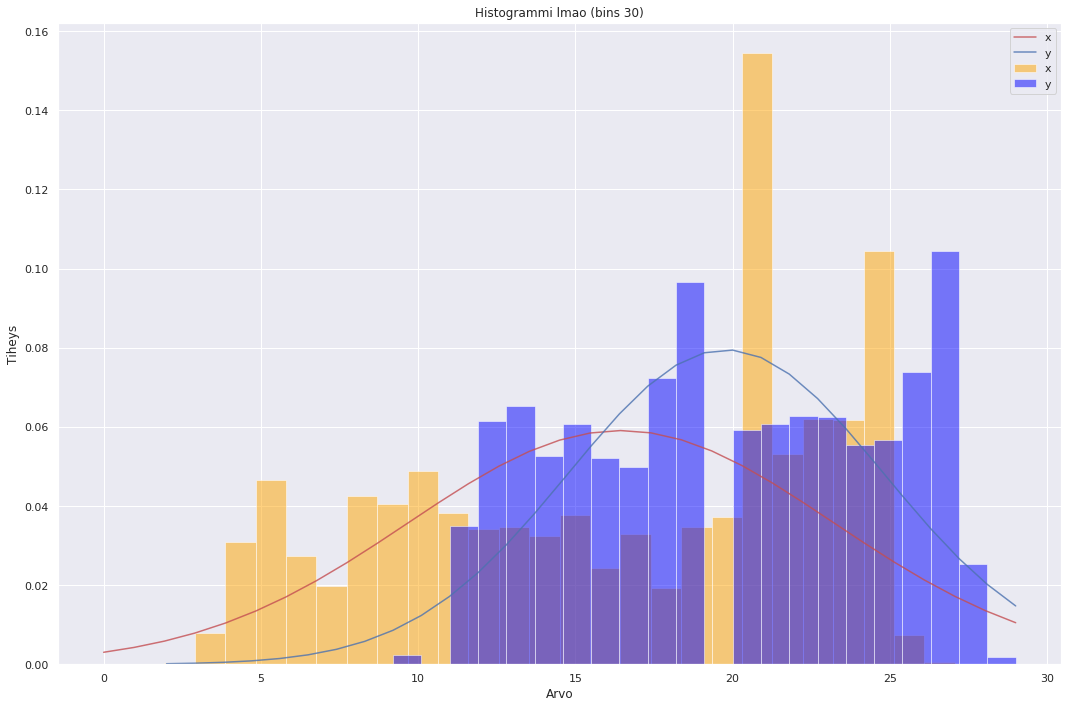

In [3]:
draw_histogram(df['x'], df['y'], 30)

In [4]:
#plot_all_routes(df_reitit, grid_size)

# Find outliers using z_score

In [5]:
df1 = find_outliers(df)



Number of missing variables in table
 ajokerta        0
node_id         0
timestamp       0
x               0
y               0
grid_id         0
kesto           0
dayofweek       0
current_hour    0
dtype: int64
------------------------------
Unique values in columns

uniques in x 30
uniques in y 26


KeyError: 'z'

# Cleaning Node_id, timestamp, q, z columns

In [ ]:
df1 = clean_dataframe(df1)
df1


In [ ]:
df1 = horrostila(df1)
df1

# Tehdään uuten tiedostoon Isolation Forestilla putsatut nodet

In [ ]:
#for i in range(len(df1.node_id.unique())):
#    df1_node = isolation_forest(df1, 0, .003, i+1)
#    print('node numero', i+1, 'valmis')
#    
#    if i == 0:
#        df1_node.to_csv('./temp_data.csv', index=False)
#    else:
#        df1_node.to_csv('./temp_data.csv',mode='a', header=False, index=False)

In [ ]:
#df1.dtypes

In [ ]:
#df1 = pd.read_csv('./temp_data.csv')
#import os
#os.remove("./temp_data.csv") 
#df1.head(5)


# Poistetaan vialliset / puutteelliset nodet

In [ ]:
#df1 = df1[df1.node_id != 13]
#df1 = df1[df1.node_id != 14]
#df1 = df1[df1.node_id != 18]
#df1 = df1[df1.node_id != 32]

# Adding xy_grid values to dataframe (50x50)

In [ ]:
grid_size = 50
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
df1.head()

In [ ]:
 # Otetaan kopio taulusta piirtämistä varten
#dftest = df1.copy()
# Laskee x:n ja y:n oudot nopeudet
#uusi_df = velocity.column_vel(df1, 'x', 'y')
# Piirtää kuvan näistä
#velocity.draw_vel(dftest, df1, 'x', 'y')

#mergedDf = df1.join(uusi_df)
#mergedDf.head()

# Write cleaned and diskretized dataframe to mariadb database

In [ ]:
# Already writed, need to make update function
#write_df_to_mariadb(df1)

# Find and draw exits

In [ ]:
in_x, in_y = sisään(df1)
out_x, out_y = ulos(df1)

draw_exits(df1, in_x, in_y, out_x, out_y)

In [ ]:
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# # Voidaan tarkistaa sijaintien oikeellisuus
sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)
plt.show()


### Erotetaan kauppareissut toisistaan

In [ ]:
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df_reitit = reitit_dataframeksi(reitit)


In [ ]:
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

In [ ]:
# Plottaa jokaisen kauppareissut erikseen.

#plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)   
# Ensimmäisissä on aika paljon häiriötä

In [ ]:
alotus, lapimeno = get_lapimeno(reitit, 50)
df_reitit['kesto']=df_reitit['kesto'].dt.total_seconds()
df_reitit = df_reitit[df_reitit["kesto"] < 7200]
df_reitit = df_reitit[df_reitit["kesto"] > 0]
df_reitit

In [ ]:
plot_lapimeno(alotus,df_reitit['kesto'])

In [ ]:
#df_reitit['kesto']=df_reitit['kesto'].dt.total_seconds()


In [ ]:
#pituus = [0, 600, 1200, 1800, 2400, 2800, 3400]
#df_pituus = pd.cut(df_reitit['kesto'], pituus)
#kesto = df_reitit['kesto']
#df_reitit_plot = df_reitit.groupby(df_pituus)['ajokerta'].count()

In [ ]:
#df_reitit_plot.plot(kind = 'hist')